In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import OneHotEncoder

class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, normalize=True):
        self.is_normalize = normalize

    def fit(self, X, y, alpha, num_iters, epsilon):

        # X transformations
        if self.is_normalize == True:
            self.X_, self.mean, self.std = self._normalize(X)
        else:
            self.X_ = X
        self.X_ = self.X_.T
 
        # Y transformations
        encoder = OneHotEncoder()
        encoder.fit(y)
        Y = encoder.transform(y).toarray()
        self.y_labels = [x[3:] for x in  encoder.get_feature_names()]
        self.y_ = Y.T

        self.w = np.full(( self.X_.shape[0],1),0.0)
        self.b = 0.0
        self.w, self.b, self.Js = self._gradient_descent(self.X_, self.y_, self.w, self.b, alpha, num_iters, epsilon, False)
        self.coef_ = self.w

    def predict(self, X, full_output=False):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if self.is_normalize:
            X_norm = (X - self.mean) / self.std
            z = self._sigmoid(np.dot(self.w.T,X_norm.T)+self.b)
        else:
            z = self._sigmoid(np.dot(self.w.T,X.T)+self.b)
    
        if full_output == True:
            y_pred = np.full((z.shape[1]), {})
            for i in range(z.shape[1]):
                y_pred[i] = { self.y_labels[j]: z[j][i] for j in range(z.shape[0])}
        else:
            y_pred = np.zeros(z.shape[1], dtype=int)
            for i in range(z.shape[1]):
                y_pred[i] = np.argmax(z[:, i])
        return y_pred

    def get_cost_history(self):
        check_is_fitted(self)
        return self.Js

    def _normalize(self, X):
        mean = np.zeros([X.shape[1]])
        std  = np.ones([X.shape[1]])
        
        for i in range(X.shape[1]):
            if (np.std(X.iloc[:, i]) != 0):
                mean[i] = np.mean(X.iloc[:, i])
                std[i] = np.std(X.iloc[:, i])
        X_new = (X - mean) / std
        return X_new, mean, std

    def _cost_function(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None

        J = (1 / m) * np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A))
        return J

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _forward_backward_propagation(self, X, Y, w, b):        
        # forward propagation
        m = X.shape[1]

        z = np.dot(w.T,X) + b
        A = self._sigmoid(z)
        cost = self._cost_function(X, Y, A)

        # backward propagation
        dz = A - Y
        derivative_weights = (1 / m) * np.dot(X, dz.T)
        derivative_bias = (1 / m) * np.sum(dz)

        return cost, derivative_weights, derivative_bias

    def _gradient_descent(self, X, Y, w, b, alpha, num_iters, epsilon, print_J=False):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]

        J_history = []

        for i in range(num_iters):
            J, delta_weights, delta_bias = self._forward_backward_propagation(X, Y, w, b)

            w = w - alpha * delta_weights
            b = b - alpha * delta_bias

            if print_J == True and i % 100 == 0:
                print(J)

            J_history.append(J)

        return w, b, J_history

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class AttackFGSM():
    # Fast Gradient Sign Method Attack
    def __init__(self, normalize=False):
        self.goal_assurance_history = []

    def fit(self, X, w, b, y, alpha, max_iters, predict_func):
        # Check that X and y have correct shape
        self.w = w
        self.b = b

        self.y_ = np.expand_dims(y.T, axis=1)
        self.X_ = X.T
      
        self.num_iters = 0
        self.X_ = self._gradient_descent(self.X_, self.y_, self.w, self.b, alpha, max_iters, predict_func)

    def _cost_function(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None

        J = (1 / m) * np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A))
        return J

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _forward_backward_propagation(self, X, Y, w, b):        
        # forward propagation
        m = X.shape[1]
        z = np.dot(w.T,X) + b
        A = self._sigmoid(z)

        # backward propagation
        dz = A - Y
        derivative_x = (1 / m) * np.dot(w, dz)
        return derivative_x

    def _is_tricked(self, X, Y, predict_func):
        # goal class position
        for i in range(Y.shape[1]):
            goal_pos = np.argmax(Y[:, i] != 0)
            if (predict_func(np.array(X))[i] != goal_pos):
                return False
        return True

    def _gradient_descent(self, X, Y, w, b, alpha, max_iters, predict_func):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]
        
        while (not self._is_tricked(X.T, Y, predict_func)) and (self.num_iters <= max_iters):
            delta_x = self._forward_backward_propagation(X, Y, w, b)

            X = X - alpha * np.sign(delta_x)
            self.num_iters += 1       

        # Antitranspose before return
        return X.T

In [6]:
filename_test = "./digit-recognizer/test.csv"
filename_train = "./digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


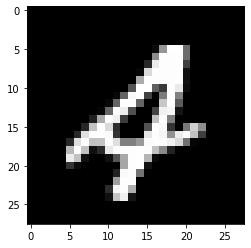

In [8]:
X_t =  X_train.values.reshape(-1,28,28,1)
g = plt.imshow(X_t[0][:, :, 0], 'gray')

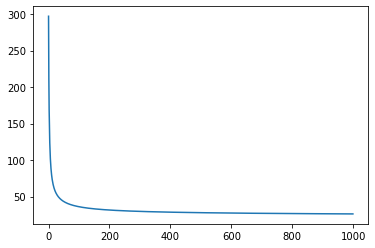

26.35476366061239


In [9]:
lg = LogisticRegression(normalize=True)
lg.fit(X_train, y_train, 0.1, 1000, 1e-20)

plot_J(lg.get_cost_history())
print(lg.get_cost_history()[-1])

In [10]:
y_pred = lg.predict(X_test)

c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\p

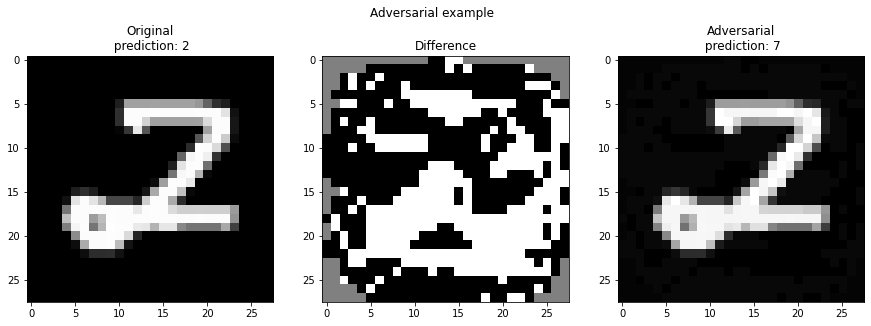

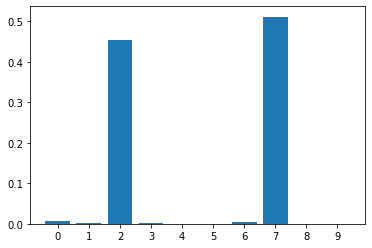

Iterations: 46; alpha: 0.1;


In [11]:
attack = AttackFGSM()
sample_idx = 0

x = np.expand_dims(X_test.iloc[sample_idx, :], axis=0)
goal = np.zeros(np.unique(y_test["label"]).shape)
goal[7] = 1
alpha = 0.1

attack.fit(x, lg.coef_, lg.b, goal, alpha, 1000, lg.predict)
adv_pred = lg.predict(np.array( attack.X_))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15,5)
fig.suptitle('Adversarial example')
ax1.imshow(X_test.values.reshape(-1,28,28,1)[sample_idx][:, :, 0], 'gray')
ax1.set_title(f"Original\n prediction: {lg.predict(x)[0]}")
ax2.imshow(X_test.values.reshape(-1,28,28,1)[sample_idx][:, :, 0] - attack.X_.reshape(28,28), "gray")
ax2.set_title(f"Difference")
ax3.imshow(attack.X_.reshape(28,28), 'gray')
ax3.set_title(f"Adversarial\n prediction: {adv_pred[0]}")

plt.show()

pred_full = lg.predict(np.array( attack.X_), full_output=True)
plt.bar(pred_full[0].keys(), pred_full[0].values())
plot_J(attack.goal_assurance_history)
plt.show()
print(f"Iterations: {attack.num_iters}; alpha: {alpha};")

Iterations: 108; alpha: 0.1;


c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
c:\users\pc\appdata\local\p

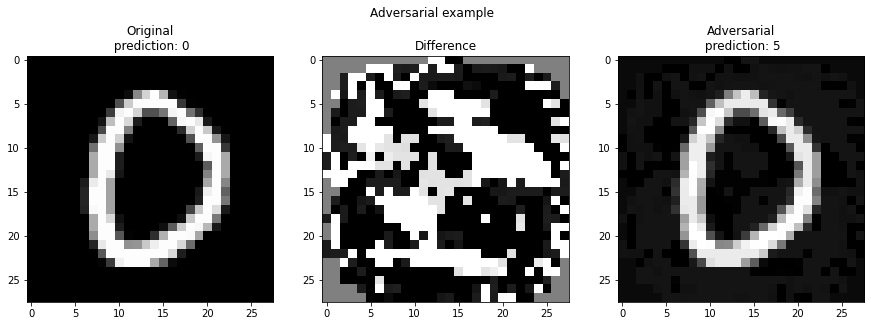

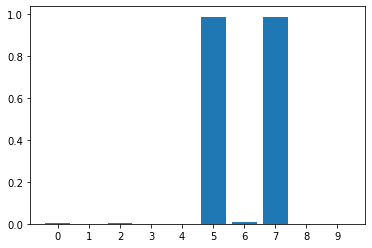

In [12]:
attack = AttackFGSM()
sample_idx = 1

x = np.expand_dims(X_test.iloc[sample_idx, :], axis=0)
goal = np.zeros(np.unique(y_test["label"]).shape)
goal[5] = 1
alpha = 0.1

attack.fit(x, lg.coef_, lg.b, goal, alpha, 1000, lg.predict)
adv_pred = lg.predict(np.array( attack.X_))
print(f"Iterations: {attack.num_iters}; alpha: {alpha};")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15,5)
fig.suptitle('Adversarial example')
ax1.imshow(X_test.values.reshape(-1,28,28,1)[sample_idx][:, :, 0], 'gray')
ax1.set_title(f"Original\n prediction: {lg.predict(x)[0]}")
ax2.imshow(X_test.values.reshape(-1,28,28,1)[sample_idx][:, :, 0] - attack.X_.reshape(28,28), "gray")
ax2.set_title(f"Difference")
ax3.imshow(attack.X_.reshape(28,28), 'gray')
ax3.set_title(f"Adversarial\n prediction: {adv_pred[0]}")

plt.show()

pred_full = lg.predict(np.array( attack.X_), full_output=True)
plt.bar(pred_full[0].keys(), pred_full[0].values())
plot_J(attack.goal_assurance_history)
plt.show()

In [13]:
y_real = np.array(y_test.iloc[:, 0])

comp = pd.DataFrame({"y_pred": y_pred, "y_real": y_real})
print(comp.head(20))

    y_pred  y_real
0        2       2
1        0       0
2        0       0
3        8       8
4        3       8
5        4       4
6        5       5
7        8       8
8        5       2
9        4       4
10       4       4
11       7       7
12       1       1
13       5       5
14       0       0
15       7       7
16       4       4
17       2       6
18       1       1
19       5       5


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
rmse = mean_squared_error(y_real, y_pred, squared=True)
mse = mean_squared_error(y_real, y_pred, squared=False)
mae = mean_absolute_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)
accuracy = int(sum(y_real == y_pred) / len(y_pred) * 100)


#print(f'Coefficients\n {theta}')
print(f'Root mean squared error: {rmse}')
print(f'Mean squared error: {mse}')
print(f'Mean absolute error: {mae}')
print(f'Coefficient of determination: {r2}')
print(f"Accuracy: {accuracy}%")

Root mean squared error: 1.5316666666666667
Mean squared error: 1.2376052143824647
Mean absolute error: 0.3264285714285714
Coefficient of determination: 0.8163789692979243
Accuracy: 90%
